# Particle Flow Filter (PFF) - Python/TensorFlow Implementation

This notebook implements the Particle Flow Filter for Lorenz 96 model using Python with TensorFlow.
Original MATLAB code by Chih-Chi Hu (chihchi@colostate.edu)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils_pff import L96_RK4, regularized_inverse, inv_SVD
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Helper Functions - Observation Operators

In [2]:
def H_linear(X):
    """
    Linear observation operator (identity mapping).
    
    Parameters:
    -----------
    X : tf.Tensor or np.ndarray
        Ensemble in state space (size: [# state variables in inner domain, # ensemble members])
    
    Returns:
    --------
    Hx : tf.Tensor or np.ndarray
        Ensemble in observation space (same size as X)
    """
    return X


def H_linear_adjoint(X):
    """
    Adjoint of linear observation operator.
    
    Parameters:
    -----------
    X : tf.Tensor or np.ndarray
        Ensemble in state space (size: [# state variables in inner domain, # ensemble members])
    
    Returns:
    --------
    dHdx : np.ndarray
        Adjoint (size: [# state variables in inner domain, # ensemble members])
    """
    dim_inner, np_ens = X.shape
    return np.ones((dim_inner, np_ens))

## Parameter Setup

In [3]:
# Experiment setup
DA_run = True      # Run ensemble with DA cycles
noDA_run = True    # Run ensemble without DA cycles
nt = 200           # Number of integration timesteps
t_start = 0        # Start time (Python uses 0-indexing)
warm_nt = 1000     # Warm up time for Lorenz model
gen_ens = True     # Generate ensemble
np_particles = 30  # Number of particles

# L96 model parameters
dim = 40           # Dimension of Lorenz 96 model
F = 8.0            # Forcing parameter
dt = 0.01          # Time resolution

# Background error covariance (for initial perturbation)
Q = 2 * np.eye(dim)
Q_inv = np.linalg.inv(Q)

# PFF kernel parameter
alpha = 1.0 / np_particles  # Tuning parameter for kernel covariance

# PFF iteration parameters
max_pseudo_step = 150      # Maximum number of iterations
eps_init = 5e-2            # Initial pseudo-timestep size (learning rate)
stop_cri = 1e-3            # Stopping criterion
stop_cri_percentage = 0.05 # Percentage-based stopping criterion
min_learning_rate = 1e-5   # Minimum learning rate

# PFF prior assumptions
io_local = True            # Use localization (recommended)
r_influ = 4                # Localization radius
io_gauss_prior = True      # Use Gaussian prior (recommended)
inflation_fac = 1.25       # Inflation factor for prior covariance
tune_C = 5 / inflation_fac # Covariance tuning for Gaussian mixture

# PFF preconditioner
pre_cond = 1               # 0 = posterior covariance, 1 = prior covariance (recommended)

# SVD condition number
cond_num = -5              # Condition number for SVD

# Observation settings
da_intv = 4                # Observation frequency (timesteps between observations)

# Linear identity observation setup
obs_den = 2                # Observation density (every obs_den-th grid is observed)
obs_input = np.arange(obs_den-1, dim, obs_den)  # Python uses 0-indexing
ny_obs = len(obs_input)
inner_domain = [[i] for i in obs_input]  # List of lists for inner domain

# Observation error
obs_err = 0.3              # Observation error standard deviation
R = obs_err**2 * np.eye(ny_obs)  # Observation error covariance
total_obs = nt // da_intv  # Total number of observations
obs_rnd = np.random.multivariate_normal(np.zeros(ny_obs), R, total_obs).T

# Storage arrays
if gen_ens:
    prior = np.zeros((dim, np_particles, total_obs))
obs = np.zeros((ny_obs, total_obs))
norm_grad_KL = np.zeros((total_obs, max_pseudo_step))

print(f"Setup complete:")
print(f"  Dimension: {dim}")
print(f"  Particles: {np_particles}")
print(f"  Total timesteps: {nt}")
print(f"  DA interval: {da_intv}")
print(f"  Total observations: {total_obs}")
print(f"  Number of obs per time: {ny_obs}")

Setup complete:
  Dimension: 40
  Particles: 30
  Total timesteps: 200
  DA interval: 4
  Total observations: 50
  Number of obs per time: 20


## Generate Truth (Warm-up and Integration)

Integrating L96 model (warm-up + simulation)...
  Timestep 200/1200
  Timestep 400/1200
  Timestep 600/1200
  Timestep 800/1200
  Timestep 1000/1200
Integration complete!


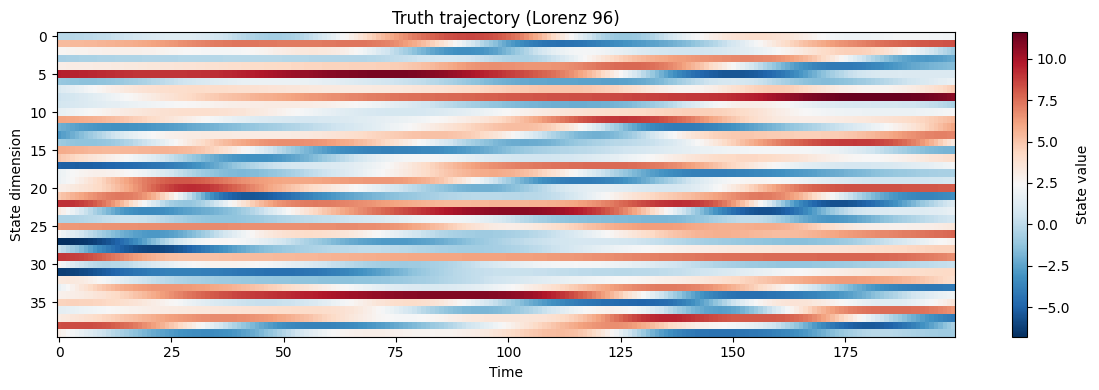

In [4]:
# Initialize truth trajectory
Xt = np.zeros((dim, warm_nt + nt))
Xt[:, 0] = F * np.ones(dim)
Xt[dim//5::dim//5, 0] = F + 1  # Perturbed IC for chaotic behavior

# Convert to TensorFlow tensor for L96_RK4
print("Integrating L96 model (warm-up + simulation)...")
for t in range(warm_nt + nt - 1):
    X_tf = tf.constant(Xt[:, t:t+1], dtype=tf.float32)
    X_next = L96_RK4(X_tf, dt, F)
    Xt[:, t+1] = X_next.numpy().flatten()
    
    if (t+1) % 200 == 0:
        print(f"  Timestep {t+1}/{warm_nt + nt}")

print("Integration complete!")

# Visualize truth
plt.figure(figsize=(12, 4))
plt.imshow(Xt[:, warm_nt:], aspect='auto', cmap='RdBu_r', interpolation='nearest')
plt.colorbar(label='State value')
plt.xlabel('Time')
plt.ylabel('State dimension')
plt.title('Truth trajectory (Lorenz 96)')
plt.tight_layout()
plt.show()

In [7]:
Xt[:, 0]

array([8., 8., 8., 8., 8., 8., 8., 8., 9., 8., 8., 8., 8., 8., 8., 8., 9.,
       8., 8., 8., 8., 8., 8., 8., 9., 8., 8., 8., 8., 8., 8., 8., 9., 8.,
       8., 8., 8., 8., 8., 8.])

## Generate Initial Ensemble

In [8]:
if gen_ens:
    # Generate initial ensemble
    ctlmean = Xt[:, warm_nt] + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
    
    X = np.zeros((dim, np_particles, nt))
    X[:, :, 0] = np.random.multivariate_normal(ctlmean, Q, np_particles).T
    
    print(f"Initial ensemble generated with {np_particles} particles")
    print(f"Initial ensemble mean: {np.mean(X[:, :, 0], axis=1)[:5]}... (first 5 dims)")
    print(f"Initial ensemble std: {np.std(X[:, :, 0], axis=1)[:5]}... (first 5 dims)")

Initial ensemble generated with 30 particles
Initial ensemble mean: [ 1.57650501  6.63759168  2.43327139 -1.62893015  3.70589483]... (first 5 dims)
Initial ensemble std: [1.54361692 1.16663106 1.24889362 1.40751653 1.36091904]... (first 5 dims)


## Run Ensemble Without DA (Free Run)

In [6]:
if noDA_run:
    print("Running ensemble without DA (free run)...")
    XnoDA = np.zeros((dim, np_particles, nt))
    XnoDA[:, :, 0] = X[:, :, 0].copy()
    
    for t in range(nt - 1):
        X_tf = tf.constant(XnoDA[:, :, t], dtype=tf.float32)
        X_next = L96_RK4(X_tf, dt, F)
        XnoDA[:, :, t+1] = X_next.numpy()
        
        if (t+1) % 50 == 0:
            print(f"  Timestep {t+1}/{nt}")
    
    print("Free run complete!")
    
    # Save to CSV
    pd.DataFrame(XnoDA[:, :, 0]).to_csv('output.csv', index=False, header=False)
    print("Initial state saved to output.csv")

Running ensemble without DA (free run)...
  Timestep 50/200
  Timestep 100/200
  Timestep 150/200
Free run complete!
Initial state saved to output.csv


## Main PFF Algorithm - Data Assimilation

In [7]:
if DA_run:
    print("\n" + "="*60)
    print("Starting Particle Flow Filter (PFF) Data Assimilation")
    print("="*60)
    
    t = t_start
    
    while t < nt - 1:
        # Determine if observation is available
        io_obs = ((t + 1) % da_intv == 0)
        io_pff = io_obs
        
        if t % 20 == 0:
            print(f"\nTimestep t={t+1}")
        
        if io_obs:
            print(f"  DA cycle at t={t+1}")
        
        # Step 1: Run the model (forecast)
        X_tf = tf.constant(X[:, :, t], dtype=tf.float32)
        X_next = L96_RK4(X_tf, dt, F)
        X[:, :, t+1] = X_next.numpy()
        
        # Step 2: Generate observation
        if io_obs:
            obs_time = (t + 1) // da_intv
            for i in range(ny_obs):
                inner_ind = inner_domain[i]
                obs[i, obs_time] = H_linear(Xt[inner_ind, warm_nt + t + 1]) + obs_rnd[i, obs_time]
        
        # Step 3: Particle Flow Filter
        if io_pff:
            # Calculate prior covariance
            X_tmp = X[:, :, t+1]
            X_mean = np.mean(X_tmp, axis=1, keepdims=True)
            X_mean_rep = np.tile(X_mean, (1, np_particles))
            C = inflation_fac * (X_tmp - X_mean_rep) @ (X_tmp - X_mean_rep).T / (np_particles - 1) / np_particles
            
            # Localization for C
            if io_local:
                tmp = np.zeros((dim, dim))
                for i in range(1, 3 * r_influ + 1):
                    diag_val = np.exp(-i**2 / r_influ**2)
                    tmp += diag_val * (np.diag(np.ones(dim - i), i) + 
                                      np.diag(np.ones(dim - i), -i) + 
                                      np.diag(np.ones(i), -(dim - i)) + 
                                      np.diag(np.ones(i), dim - i))
                mask = tmp + np.eye(dim)
                C = C * mask
                C_inv = inv_SVD(C, cond_num)
                
            else:
                C_inv = inv_SVD(C, cond_num)
            
            B = C * np_particles
            B_inv = C_inv / np_particles
            
            # Preconditioner matrix
            if pre_cond == 1:
                qn = B / inflation_fac
            else:
                # Need to calculate posterior covariance (not implemented here)
                qn = B / inflation_fac
            
            # Initialize PFF iteration
            s = 0
            ct = 0
            norm_grad_KL[obs_time, 0] = 1e8
            eps = eps_init * np.ones(max_pseudo_step)
            
            pseudo_X = np.zeros((dim, np_particles, max_pseudo_step))
            pseudo_X[:, :, 0] = X_mean_rep + (X_tmp - X_mean_rep)
            grad_KL = np.zeros((dim, np_particles, max_pseudo_step))
            
            # Main PFF iteration loop
            while s < max_pseudo_step - 1:
                if s > 0 and norm_grad_KL[obs_time, s-1] <= stop_cri:
                    break
                
                Hx = np.zeros((ny_obs, np_particles))
                dHdx = np.zeros((ny_obs, dim, np_particles))
                
                # Evaluate observation operator and its adjoint
                for i in range(ny_obs):
                    inner_ind = inner_domain[i]
                    Hx[i, :] = H_linear(pseudo_X[inner_ind, :, s]).flatten()
                    tmp_dHdx = H_linear_adjoint(pseudo_X[inner_ind, :, s])
                    dHdx[i, inner_ind, :] = tmp_dHdx
                
                # Calculate gradient of log posterior
                p_obs = np.zeros((dim, np_particles))
                p_bkg = np.zeros((dim, np_particles))
                
                for i in range(np_particles):
                    if io_gauss_prior:
                        p_bkg[:, i] = -B_inv @ (pseudo_X[:, i, s] - X_mean.flatten())
                    else:
                        # Gaussian mixture prior (not fully implemented here)
                        p_bkg[:, i] = -B_inv @ (pseudo_X[:, i, s] - X_mean.flatten())
                    
                    HT = dHdx[:, :, i].T
                    p_obs[:, i] = HT @ np.linalg.solve(R, obs[:, obs_time] - Hx[:, i])
                
                tmp_grad_log_post = p_obs + p_bkg
                
                # Calculate particle flow (grad_KL)
                grad_KL[:, :, s] = 0.0
                
                for d in range(dim):
                    tmp_K = np.zeros((np_particles, np_particles))
                    tmp_grad_K = np.zeros((np_particles, np_particles))
                    
                    for i in range(np_particles):
                        for j in range(i, np_particles):
                            diff = pseudo_X[d, i, s] - pseudo_X[d, j, s]
                            tmp_K[i, j] = np.exp(-0.5 * diff**2 / (B[d, d] * alpha))
                            tmp_grad_K[i, j] = -tmp_K[i, j] / (B[d, d] * alpha) * (pseudo_X[d, j, s] - pseudo_X[d, i, s])
                            
                            # Symmetry
                            tmp_K[j, i] = tmp_K[i, j]
                            tmp_grad_K[j, i] = -tmp_grad_K[i, j]
                        
                        grad_KL[d, i, s] = np.sum(tmp_K[i, :] * tmp_grad_log_post[d, :] + tmp_grad_K[i, :]) / np_particles
                
                norm_grad_KL[obs_time, s] = np.sqrt(np.sum(grad_KL[:, :, s]**2) / (dim * np_particles))
                
                if s % 10 == 0:
                    print(f"    Iteration s={s}, norm={norm_grad_KL[obs_time, s]/norm_grad_KL[obs_time, 0]*100:.2f}%, eps={eps[s]:.2e}")
                
                # Adaptive learning rate
                if s == 0:
                    stop_cri = stop_cri_percentage * norm_grad_KL[obs_time, 0]
                    pseudo_X[:, :, s+1] = pseudo_X[:, :, s] + eps[s] * (qn @ grad_KL[:, :, s])
                    s += 1
                    ct += 1
                elif eps[s] < min_learning_rate:
                    print("    [Note] Learning rate too small, break!")
                    break
                elif s >= 1 and norm_grad_KL[obs_time, s] > 1.02 * norm_grad_KL[obs_time, s-1]:
                    eps[s-1:] = eps[s] / 1.5
                    s -= 1
                    ct = 0
                    if s % 10 == 0:
                        print(f"    [Note] eps changed to {eps[s]:.2e}, redo iteration")
                elif ct >= 7 and norm_grad_KL[obs_time, s] <= 1.02 * norm_grad_KL[obs_time, s-1]:
                    eps[s:] = eps[s] * 1.5
                    pseudo_X[:, :, s+1] = pseudo_X[:, :, s] + eps[s] * (qn @ grad_KL[:, :, s])
                    s += 1
                    ct = 0
                else:
                    pseudo_X[:, :, s+1] = pseudo_X[:, :, s] + eps[s] * (qn @ grad_KL[:, :, s])
                    s += 1
                    ct += 1
            
            s_end = s
            prior[:, :, obs_time] = X[:, :, t+1]
            X[:, :, t+1] = pseudo_X[:, :, s_end]
            
            print(f"  PFF completed in {s_end} iterations")
        
        t += 1
    
    print("\n" + "="*60)
    print("PFF Data Assimilation Complete!")
    print("="*60)


Starting Particle Flow Filter (PFF) Data Assimilation

Timestep t=1
  DA cycle at t=4
    Iteration s=0, norm=100.00%, eps=5.00e-02


/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_21741/984934522.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs[i, obs_time] = H_linear(Xt[inner_ind, warm_nt + t + 1]) + obs_rnd[i, obs_time]


    Iteration s=10, norm=12.51%, eps=7.50e-02
  PFF completed in 18 iterations
  DA cycle at t=8
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=52.61%, eps=7.50e-02
    Iteration s=20, norm=29.28%, eps=1.13e-01
    Iteration s=30, norm=16.06%, eps=1.69e-01
    Iteration s=40, norm=8.75%, eps=3.80e-01
  PFF completed in 50 iterations
  DA cycle at t=12
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=59.64%, eps=7.50e-02
    Iteration s=20, norm=35.07%, eps=1.13e-01
    Iteration s=30, norm=19.77%, eps=1.69e-01
    Iteration s=40, norm=9.96%, eps=3.80e-01
    Iteration s=50, norm=6.48%, eps=2.53e-01
  PFF completed in 58 iterations
  DA cycle at t=16
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=54.58%, eps=7.50e-02
    Iteration s=20, norm=32.13%, eps=1.13e-01
    Iteration s=30, norm=18.78%, eps=1.69e-01
    Iteration s=40, norm=10.65%, eps=3.80e-01
    Iteration s=50, norm=6.69%, eps=2.53e-01
    Iteration s=60, n

## Results Analysis and Visualization


RMSE Statistics:
  DA run - Mean RMSE: 0.3050
  No-DA run - Mean RMSE: 2.7990
  Improvement: 89.10%


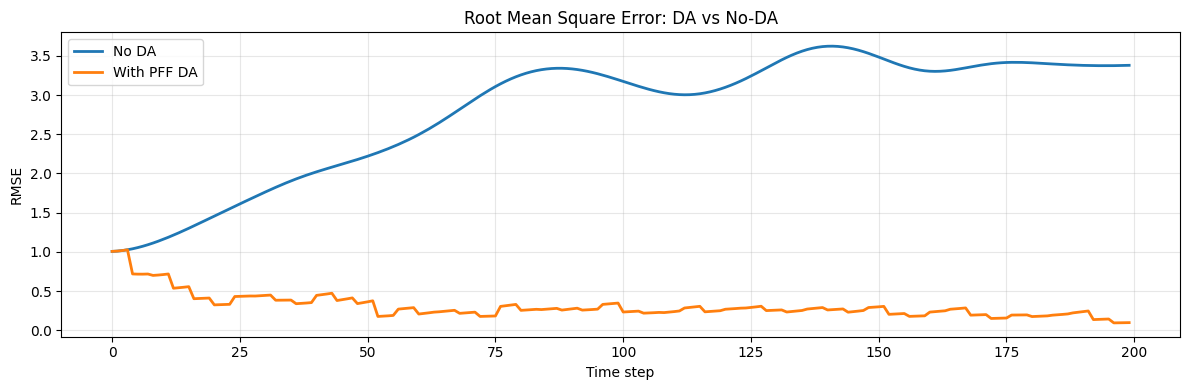

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_21741/3283224533.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


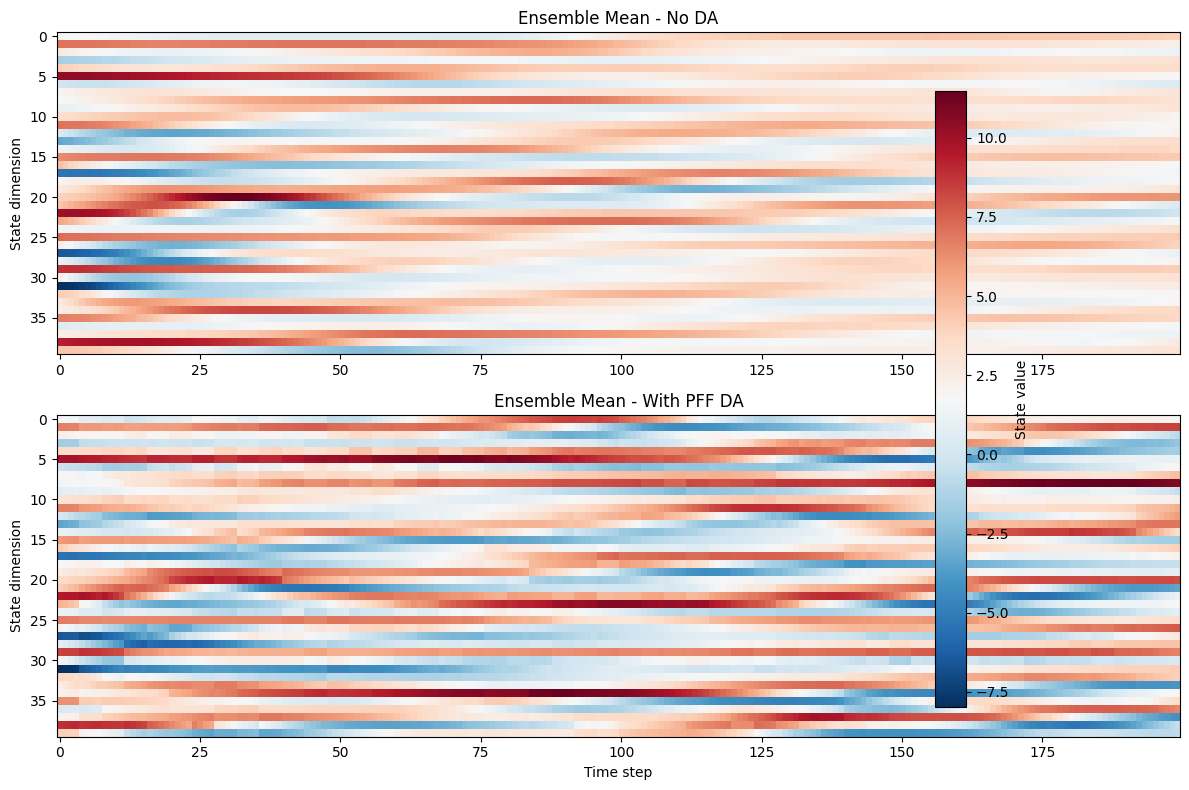

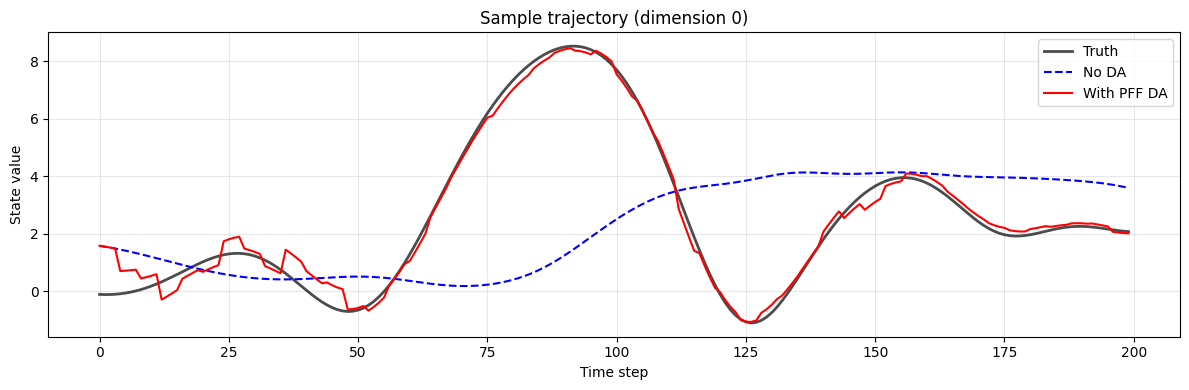

In [8]:
# Calculate RMSE for both DA and no-DA runs
if DA_run and noDA_run:
    truth = Xt[:, warm_nt:warm_nt+nt]
    
    # Ensemble mean
    X_mean_DA = np.mean(X, axis=1)
    X_mean_noDA = np.mean(XnoDA, axis=1)
    
    # RMSE over time
    rmse_DA = np.sqrt(np.mean((X_mean_DA - truth)**2, axis=0))
    rmse_noDA = np.sqrt(np.mean((X_mean_noDA - truth)**2, axis=0))
    
    print(f"\nRMSE Statistics:")
    print(f"  DA run - Mean RMSE: {np.mean(rmse_DA):.4f}")
    print(f"  No-DA run - Mean RMSE: {np.mean(rmse_noDA):.4f}")
    print(f"  Improvement: {(1 - np.mean(rmse_DA)/np.mean(rmse_noDA))*100:.2f}%")
    
    # Plot RMSE comparison
    plt.figure(figsize=(12, 4))
    plt.plot(rmse_noDA, label='No DA', linewidth=2)
    plt.plot(rmse_DA, label='With PFF DA', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('RMSE')
    plt.title('Root Mean Square Error: DA vs No-DA')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot ensemble spread
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # No-DA run
    axes[0].imshow(X_mean_noDA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    axes[0].set_title('Ensemble Mean - No DA')
    axes[0].set_ylabel('State dimension')
    
    # DA run
    im = axes[1].imshow(X_mean_DA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    axes[1].set_title('Ensemble Mean - With PFF DA')
    axes[1].set_xlabel('Time step')
    axes[1].set_ylabel('State dimension')
    
    plt.colorbar(im, ax=axes, label='State value')
    plt.tight_layout()
    plt.show()
    
    # Plot sample trajectory
    sample_dim = 0
    plt.figure(figsize=(12, 4))
    plt.plot(truth[sample_dim, :], 'k-', linewidth=2, label='Truth', alpha=0.7)
    plt.plot(X_mean_noDA[sample_dim, :], 'b--', linewidth=1.5, label='No DA')
    plt.plot(X_mean_DA[sample_dim, :], 'r-', linewidth=1.5, label='With PFF DA')
    plt.xlabel('Time step')
    plt.ylabel('State value')
    plt.title(f'Sample trajectory (dimension {sample_dim})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## PFF Convergence Analysis

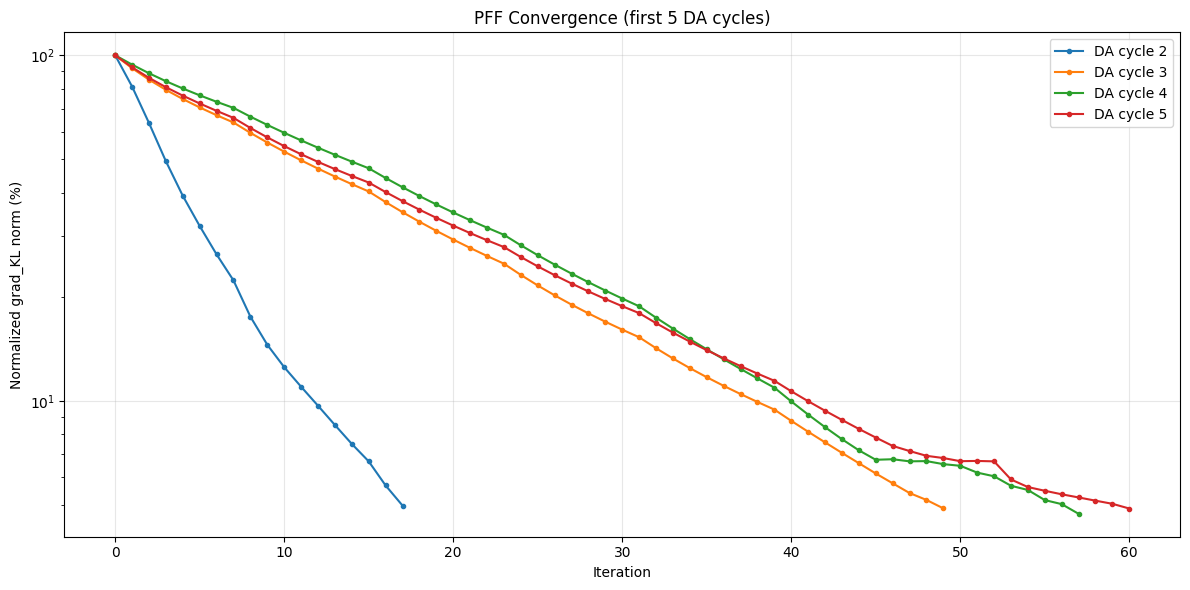


PFF Iteration Statistics:
  Mean iterations per DA cycle: 96.8
  Min iterations: 18
  Max iterations: 149


In [9]:
if DA_run:
    # Plot convergence of gradient norm
    plt.figure(figsize=(12, 6))
    
    for obs_time in range(min(5, total_obs)):  # Plot first 5 DA cycles
        valid_idx = norm_grad_KL[obs_time, :] > 0
        if np.any(valid_idx):
            iterations = np.arange(max_pseudo_step)[valid_idx]
            norms = norm_grad_KL[obs_time, valid_idx]
            plt.semilogy(iterations, norms / norms[0] * 100, 
                        marker='o', markersize=3, label=f'DA cycle {obs_time+1}')
    
    plt.xlabel('Iteration')
    plt.ylabel('Normalized grad_KL norm (%)')
    plt.title('PFF Convergence (first 5 DA cycles)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    iterations_per_cycle = []
    for obs_time in range(total_obs):
        valid_idx = norm_grad_KL[obs_time, :] > 0
        if np.any(valid_idx):
            iterations_per_cycle.append(np.sum(valid_idx))
    
    if iterations_per_cycle:
        print(f"\nPFF Iteration Statistics:")
        print(f"  Mean iterations per DA cycle: {np.mean(iterations_per_cycle):.1f}")
        print(f"  Min iterations: {np.min(iterations_per_cycle)}")
        print(f"  Max iterations: {np.max(iterations_per_cycle)}")

In [10]:
print("\n" + "="*60)
print("Particle Flow Filter Demo Complete!")
print("="*60)


Particle Flow Filter Demo Complete!
